In [2]:
import math
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler 
import matplotlib.pyplot as plt
!pip install tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

stock_data = yf.download('AAPL', start='2016-01-01', end='2021-10-01')
stock_data.head()

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


Defaulting to user installation because normal site-packages is not writeable
[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-12-31,26.752501,26.757500,26.205000,26.315001,24.130871,163649200
2016-01-04,25.652500,26.342501,25.500000,26.337500,24.151495,270597600
2016-01-05,26.437500,26.462500,25.602501,25.677500,23.546274,223164000
2016-01-06,25.139999,25.592501,24.967501,25.174999,23.085489,273829600
2016-01-07,24.670000,25.032499,24.107500,24.112499,22.111174,324377600


Text(0, 0.5, 'Prices ($)')

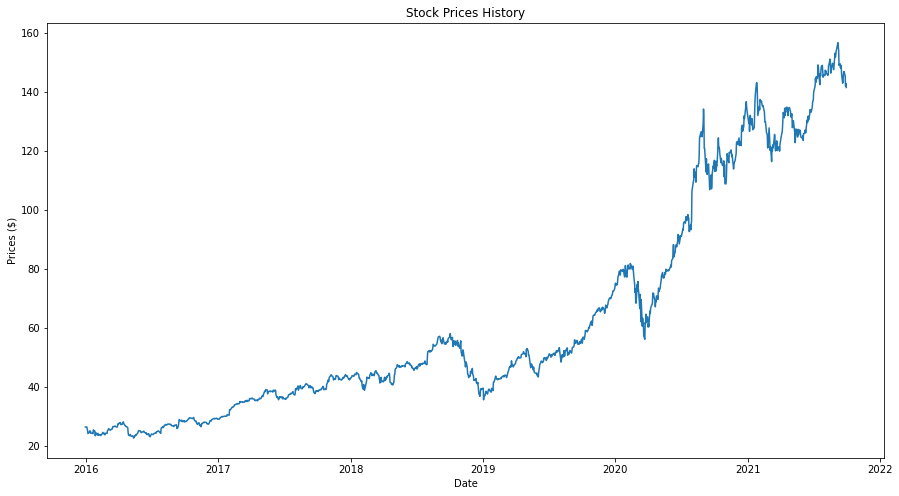

In [3]:
plt.figure(figsize=(15, 8))
plt.title('Stock Prices History')
plt.plot(stock_data['Close'])
plt.xlabel('Date')
plt.ylabel('Prices ($)')

In [4]:
close_prices = stock_data['Close']
values = close_prices.values
training_data_len = math.ceil(len(values)* 0.8)

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(values.reshape(-1,1))
train_data = scaled_data[0: training_data_len, :]

x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [5]:
test_data = scaled_data[training_data_len-60: , : ]
x_test = []
y_test = values[training_data_len:]

for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [6]:
model = keras.Sequential()
model.add(layers.LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(layers.LSTM(100, return_sequences=False))
model.add(layers.Dense(25))
model.add(layers.Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 100)           40800     
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 25)                2525      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 123,751
Trainable params: 123,751
Non-trainable params: 0
_________________________________________________________________


In [7]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size= 1, epochs=3)

Epoch 1/3
1099/1099 [==============================] - 11s 9ms/step - loss: 6.7482e-04
Epoch 2/3
1099/1099 [==============================] - 10s 9ms/step - loss: 4.4187e-04
Epoch 3/3
1099/1099 [==============================] - 10s 9ms/step - loss: 2.7296e-04


In [8]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

10/10 [==============================] - 1s 8ms/step


14.674488899204558

C:\Users\2020PITAIDS156\AppData\Local\Temp\ipykernel_2448\154904543.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['Predictions'] = predictions


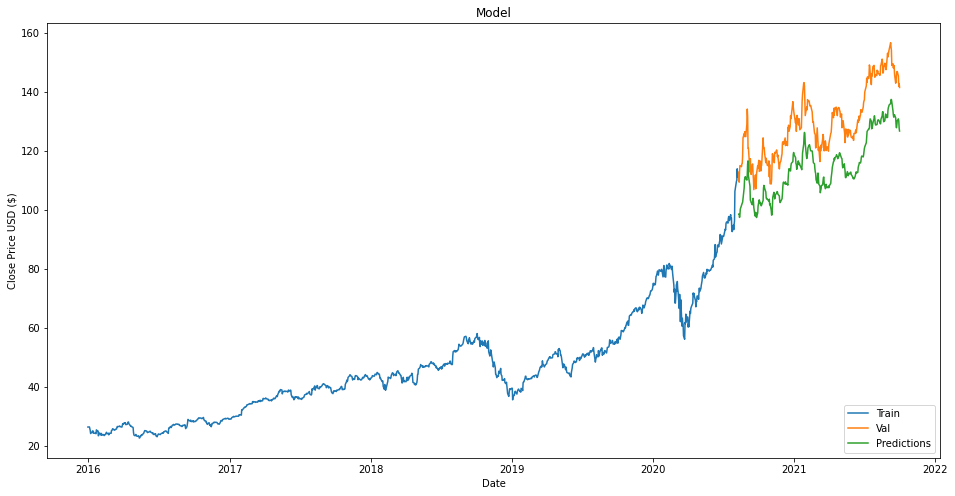

In [9]:
data = stock_data.filter(['Close'])
train = data[:training_data_len]
validation = data[training_data_len:]
validation['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train)
plt.plot(validation[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()